# Applying Deep Learning to solve a Client Success problem - Duty Manager call prediction

GOAL: tackle a day-to-day Db2 Client Success problem using deep learning

PROBLEM CHOSEN: predict likelihood a ticket will generate a duty manager call

DATA SOURCE: ticketing dashboard (ticket details) 

FEATURES: TBD
    


APPROACH: start with a basic, working DL model and simplify/augment to optimizer prediction accuracy
- using this article on structured DL (i.e. DL on structured data, as opposed to common DL examples on unstructured data like images & audio) https://towardsdatascience.com/structured-deep-learning-b8ca4138b848 as a starting point, look for some examples of end-to-end DL on structured data. This article refers to a Kaggle competition on structured data, an entry in which https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl , for example, is a great end-to-end example
- use Keras (Python DL framework built on top of TensorFlow) - sweet spot for a simple, working DL model. Keras has decent documentation and a big enough community that answers to many questions are readily available
- once input data working through model, tune the following parameters to optimize validation/test accuracy (accuracy of prediction on data not used to generate model weights):
- learning rate (to avoid local minima and oscillation)
- dropout rate (control overfitting by randomly dropping nodes)
- lambda for L2 regularization (control overfitting by "suppressing" large weights)
- batch size (the number of training examples in a forward/backward pass)
- epochs run (number of complete passes through dataset)

ENVIRONMENTS USED:
- public cloud DSX: for most development and testing after initial setup and prior to adding non-Db2 data. PROS: convenient, persistent sessions, no cost; CONS: performance ~ 30% slower than PaperSpace, memory errors trying to run model on larger data set including text analysis
- Paperspace (https://www.paperspace.com/) low-cost generic GPU-enabled Linux environemnt. Used instructions from Jeremy Howard fast.ai course V2 to setup. PROS: better perf, able to handle text processing w. largest data set without memory errors, standard filesystem; CONS: setup not straightforward, inconvenience of having to start & stop environment
- initial development done on Paperspace, moved to DSX once the basics were working, then back to Paperspace after the larger data set began to generate memory errors in DSX

SOURCE DATA :

OVERVIEW OF CODE:
- ingest CSVs: need distinct code for DSX and paper
- various cleansing / slicing and dicing to generate additional features (e.g. year and day of week from date opened). Several variations attempted (e.g. make severity a continuous variable, distort severity at extremes, exclude some severities, exclude some TTR ranges) 
- define label / target: new column in dataframe that is 0 or 1 depending on whether TTR is less than or more than 1 day
- split data into training (which will be further split into training/validation) and test data sets (training data used to generate model weights; validation set used to track how well model predicts actual targets as hyperparameters are tuned; test set used to validate entire model (learned weights and hyperparameters)
- fill in missing values for all features
- in categorical columns (all feature columns currently) replace values (e.g. "CANADA", "JAPAN" for Country) with integer IDs
- process text columns - replace words with vector of integer IDs
- define Keras model:
- embedding layers for all categorical features (embeddings are vectors used to learn patterns for categorical data - https://en.wikipedia.org/wiki/Word_embedding )
- RNN layer for text feature
- single dense output layer w. sigmoid activation to output TTR prediction

CURRENT HWMs:

VARIATIONS ATTEMPTED:

DL Glossary: https://deeplearning4j.org/glossary

In [1]:
# set overall parameters

dsxmode = True # overall is this being run in DSX?

testproportion = 0.01 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = False
includetext = True # switch to determine whether text fields are included in model
targetthresh = 6.0
emptythresh = 1000
# to address imbalance in training data between zero (above targetthresh) and detractor (below targetthresh) specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 4.5

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.00003 #0.003
l2_lambda = 0.00003 #7.5


In [2]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
from dateutil import relativedelta
from io import StringIO
import pandas as pd

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
import seaborn as sns


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data input

Read in data from external source:
- DSX - access data from DWoC table


In [3]:
# The code was removed by DSX for sharing.

,CASE_NUMBER,SUBJECT,OWNER_LAST_NAME,ACCOUNT_NAME_TEXT,CONTACT_NAME,ACCOUNT_PRIORITY,LEGACY_PROBLEM_NUMBER,SEVERITY_LEVEL,CASE_OWNER_ALIAS,BLUE_DIAMOND_ACCOUNT,COUNTRY,WATSON_SKILL_SUGGESTION_(DEPRECATED),STATUS,DATE_OPENED
0,TS000003163,FMP exiting with error and HeadExtentID 260611...,Ma,BELASTINGDIENST CAO,"Vannisselroy, Koen",Analytics-GEP,"28,585,211,788",3 - Minor business impact,majason,No,NL,None,Closed by IBM,08/11/2017
1,TS000003166,W R db2 load process hang for loading 5.8T rec...,BADIGER,CA Franchise Tax Board,"Jiang, Lily",None,"65,923,227,000",2 - Significant impact (any system is down),sbad,No,US,None,Closed - Archived,09/06/2017
2,TS000007186,UPDATE SYSSTAT.INDEXES hangs,Koranteng-Asante,"Lloyds Banking Group Service Delivery, Group IT","Nelson, Philip",None,Not Applicable,2 - Significant impact (any system is down),asan,No,GB,None,Closed - Archived,9/21/2017
3,TS000007630,Notified Load operation fails after revoking P...,Koranteng-Asante,STATE OF CONNECTICUT,"McCabe, Barbara",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),asan,No,US,None,Waiting for IBM,9/26/2017
4,TS000027965,Sporadic SQL SP slow performance due to invali...,Ma,21ST CENTURY INSURANCE AND FINANCIAL SERVICES,"Pentyala, Dileep Kumar",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),majason,No,US,None,Waiting for IBM,11/01/2017


In [4]:
# The code was removed by DSX for sharing.

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_NAME,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER
0,TS000797520,Db2 Adv Supp,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Wyndham Worldwide,SQL Replicaton using for DB migration,Srikanth Vangaveti,Not Applicable
1,TS000797566,Kevi,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",MASTERCARD TECHNOLOGIES LLC,Ingest Utility,Tom Glaser,Not Applicable
2,TS000797583,Jerry,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",TaiKang Insurance Group CO. LTD,Attn Pals(NeedHelp)|GCGTSC@ZY:Db2:,Support ETL,"92,185,124,672"
3,TS000797592,aball,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows","Kansas City Southern Railway Company, The",Performance,Victor Burke,Not Applicable
4,TS000797627,jhas,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows","Morgan Stanley & Company, Inc.",Can't force application (duplicate TS000161444),jianyu lu,Not Applicable


In [5]:
dm_cases.shape

(96, 14)

In [6]:
merged_data.shape

(7086, 9)

In [7]:
# columns = ['Col1', 'Col2', ...]
# df.drop(columns, inplace=True, axis=1)
dm_cases["target"] = 1

dm_cases.head()

,CASE_NUMBER,SUBJECT,OWNER_LAST_NAME,ACCOUNT_NAME_TEXT,CONTACT_NAME,ACCOUNT_PRIORITY,LEGACY_PROBLEM_NUMBER,SEVERITY_LEVEL,CASE_OWNER_ALIAS,BLUE_DIAMOND_ACCOUNT,COUNTRY,WATSON_SKILL_SUGGESTION_(DEPRECATED),STATUS,DATE_OPENED,target
0,TS000003163,FMP exiting with error and HeadExtentID 260611...,Ma,BELASTINGDIENST CAO,"Vannisselroy, Koen",Analytics-GEP,"28,585,211,788",3 - Minor business impact,majason,No,NL,None,Closed by IBM,08/11/2017,1
1,TS000003166,W R db2 load process hang for loading 5.8T rec...,BADIGER,CA Franchise Tax Board,"Jiang, Lily",None,"65,923,227,000",2 - Significant impact (any system is down),sbad,No,US,None,Closed - Archived,09/06/2017,1
2,TS000007186,UPDATE SYSSTAT.INDEXES hangs,Koranteng-Asante,"Lloyds Banking Group Service Delivery, Group IT","Nelson, Philip",None,Not Applicable,2 - Significant impact (any system is down),asan,No,GB,None,Closed - Archived,9/21/2017,1
3,TS000007630,Notified Load operation fails after revoking P...,Koranteng-Asante,STATE OF CONNECTICUT,"McCabe, Barbara",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),asan,No,US,None,Waiting for IBM,9/26/2017,1
4,TS000027965,Sporadic SQL SP slow performance due to invali...,Ma,21ST CENTURY INSURANCE AND FINANCIAL SERVICES,"Pentyala, Dileep Kumar",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),majason,No,US,None,Waiting for IBM,11/01/2017,1


In [8]:
dmcollist = list(dm_cases)
dmexlist = ['CASE_NUMBER','target']
# collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty))
dmcollist = list(set(dmcollist) - set(dmexlist))
dmcollist

['DATE_OPENED',
 'CONTACT_NAME',
 'ACCOUNT_PRIORITY',
 'LEGACY_PROBLEM_NUMBER',
 'STATUS',
 'SUBJECT',
 'COUNTRY',
 'ACCOUNT_NAME_TEXT',
 'OWNER_LAST_NAME',
 'SEVERITY_LEVEL',
 'CASE_OWNER_ALIAS',
 'WATSON_SKILL_SUGGESTION_(DEPRECATED)',
 'BLUE_DIAMOND_ACCOUNT']

In [9]:
# df.drop(columns, inplace=True, axis=1)
dm_cases.drop(dmcollist, inplace=True, axis=1)

In [10]:
dm_cases.target.value_counts()

1    96
Name: target, dtype: int64

In [11]:
dm_cases.shape

(96, 2)

In [12]:
# pd.merge(restaurant_ids_dataframe, restaurant_review_frame, 
# on='business_id', how='outer')
merged_data = pd.merge(merged_data,dm_cases,on= 'CASE_NUMBER', how='outer')

In [13]:
merged_data.target.value_counts()

1.0    96
Name: target, dtype: int64

In [14]:
# df['column']=df['column'].fillna(value)
merged_data['target']=merged_data['target'].fillna(0.0)
merged_data.target.value_counts()

0.0    7010
1.0      96
Name: target, dtype: int64

In [15]:
merged_data.shape

(7106, 10)

In [16]:
merged_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_NAME,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
0,TS000797520,Db2 Adv Supp,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Wyndham Worldwide,SQL Replicaton using for DB migration,Srikanth Vangaveti,Not Applicable,0.0
1,TS000797566,Kevi,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",MASTERCARD TECHNOLOGIES LLC,Ingest Utility,Tom Glaser,Not Applicable,0.0
2,TS000797583,Jerry,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",TaiKang Insurance Group CO. LTD,Attn Pals(NeedHelp)|GCGTSC@ZY:Db2:,Support ETL,"92,185,124,672",0.0
3,TS000797592,aball,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows","Kansas City Southern Railway Company, The",Performance,Victor Burke,Not Applicable,0.0
4,TS000797627,jhas,4/20/2018,DB2 for LUW,"Db2 Linux, Unix and Windows","Morgan Stanley & Company, Inc.",Can't force application (duplicate TS000161444),jianyu lu,Not Applicable,1.0


In [17]:
print("md shape",merged_data.shape)

md shape (7106, 10)


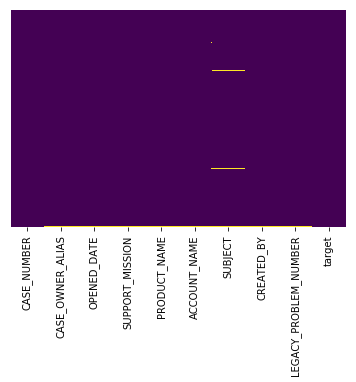

In [18]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [19]:
nearempty = []
for c in merged_data.columns:
    if np.sum(merged_data[c].isnull()) >= emptythresh :
        print(c)
        nearempty.append(c)
print(nearempty)

[]


# Clean up data

Go through steps to prepare data.

# Define test / training sets; fill in missing values; encode categorical values; process text field

In [20]:
# get training and test data set
# test_size was 0.3 up to Jan 22

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)
print("zero target values",(merged_data["target"]==0).sum())
print("one target values",(merged_data["target"]==1).sum())

Through train test split. Test proportion:
0.01
zero target values 7010
one target values 96


In [21]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['CASE_NUMBER', 'CASE_OWNER_ALIAS', 'OPENED_DATE', 'SUPPORT_MISSION', 'PRODUCT_NAME', 'ACCOUNT_NAME', 'SUBJECT', 'CREATED_BY', 'LEGACY_PROBLEM_NUMBER', 'target']


In [22]:
# define the required column lists
#textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
textcols = ['SUBJECT']
excludefromcolist = ['CASE_NUMBER','target']
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty))

# print column list lengths:
print("allcols",len(allcols))
print("nearempty",len(nearempty))
print("textcols",len(textcols))
print("collist",len(collist))

allcols 10
nearempty 0
textcols 1
collist 7


In [23]:


print("testo")
print("length collist",len(collist))
print("collist",collist)


testo
length collist 7
collist ['PRODUCT_NAME', 'ACCOUNT_NAME', 'LEGACY_PROBLEM_NUMBER', 'SUPPORT_MISSION', 'CASE_OWNER_ALIAS', 'OPENED_DATE', 'CREATED_BY']


In [24]:
# fill missing values
print("before mv")
def fill_missing(dataset,collist):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

train = fill_missing(train,allcols)
test = fill_missing(test,allcols)
train.head(3)


before mv


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_NAME,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
1378,TS000145499,STBG,3/15/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",BIOTRONIK SE & Co. KG,eDM export fail with errors,Smit Kalwal,Not Applicable,0.0
2579,TS000174500,NAKA,04/09/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NTT DATA SEKISUI SYSTEMS CORPORATION,fix pack????????,Hiroaki Nakatsubo,Not Applicable,0.0
4370,TS000164886,juil,04/02/2018,DB2 for LUW,"Db2 Linux, Unix and Windows","KTB Computer Services Co., LTD",db2ckupgrade Fail,sanprasirt boonma,Not Applicable,0.0


In [25]:
# process categorical data
# replace values with category IDs in the following columns
# 


le = LabelEncoder()

for col in collist:
    if verboseout:
        print("processing ",col)
    le.fit(np.hstack([train[col], test[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    
del le


train.head(5)
    

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_NAME,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
1378,TS000145499,86,67,0,4,254,eDM export fail with errors,1530,2435,0.0
2579,TS000174500,70,33,0,4,1340,fix pack????????,581,2435,0.0
4370,TS000164886,154,26,0,4,1113,db2ckupgrade Fail,1960,2435,0.0
6782,TS000837941,72,97,0,4,1613,DB2 Start Errors,415,2435,0.0
6895,TS000179568,50,36,0,4,1277,Web????????????????????,1603,1112,0.0


In [26]:
train['SUBJECT'].head(3)

1378    eDM export fail with errors
2579               fix pack????????
4370              db2ckupgrade Fail
Name: SUBJECT, dtype: object

In [27]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    raw_text = train[col].str.lower()
    tok_raw = Tokenizer()
    tok_raw.fit_on_texts(raw_text)
    train[col] = tok_raw.texts_to_sequences(train[col].str.lower())
    test[col] = tok_raw.texts_to_sequences(test[col].str.lower())



Using TensorFlow backend.
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
train['SUBJECT'].head(10)

1378                            [2823, 302, 303, 12, 108]
2579                                           [164, 195]
4370                                           [551, 303]
6782                                        [1, 125, 108]
6895                                                [718]
6010    [3, 222, 1, 880, 619, 9, 4, 75, 278, 1, 304, 7...
1971             [179, 19, 26, 1933, 27, 39, 7, 2, 33, 6]
5314    [47, 20, 104, 2, 1537, 285, 20, 460, 796, 19, ...
3676                                      [174, 45, 2824]
4856                 [26, 17, 130, 37, 259, 663, 13, 101]
Name: SUBJECT, dtype: object

In [29]:
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
'''
print("res decr max",train['Resolution_Description'].max())
print("subject",train['SUBJECT'].max())
print("orc",train['Other_Reason_for_Cancellation'].max())
print("Reason_for_Reopening",train['Reason_for_Reopening'].max())
print("cmr number max",train['CMR_Number'].max())
print("npmaxer ",np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
print("test npmaxer ",np.max([np.max(test['Resolution_Description'].max()), np.max(test['Subject'].max()),np.max(test['Other_Reason_for_Cancellation'].max()),np.max(test['Reason_for_Reopening'].max())])) 
#print("overall npmaxer ",np.max([np.max(merged_data['Resolution_Description'].max()), np.max(merged_data['Subject'].max()),np.max(merged_data['Other_Reason_for_Cancellation'].max()),np.max(merged_data['Reason_for_Reopening'].max())]))
'''

'\nprint("res decr max",train[\'Resolution_Description\'].max())\nprint("subject",train[\'SUBJECT\'].max())\nprint("orc",train[\'Other_Reason_for_Cancellation\'].max())\nprint("Reason_for_Reopening",train[\'Reason_for_Reopening\'].max())\nprint("cmr number max",train[\'CMR_Number\'].max())\nprint("npmaxer ",np.max([np.max(train[\'Resolution_Description\'].max()), np.max(train[\'Subject\'].max()),np.max(train[\'Other_Reason_for_Cancellation\'].max()),np.max(train[\'Reason_for_Reopening\'].max())])) \nprint("test npmaxer ",np.max([np.max(test[\'Resolution_Description\'].max()), np.max(test[\'Subject\'].max()),np.max(test[\'Other_Reason_for_Cancellation\'].max()),np.max(test[\'Reason_for_Reopening\'].max())])) \n#print("overall npmaxer ",np.max([np.max(merged_data[\'Resolution_Description\'].max()), np.max(merged_data[\'Subject\'].max()),np.max(merged_data[\'Other_Reason_for_Cancellation\'].max()),np.max(merged_data[\'Reason_for_Reopening\'].max())]))\n'

In [30]:
# part 2 of text processing
# max_abstract_seq = np.max([np.max(train.seq_abstract.apply(lambda x: len(x))), np.max(test.seq_abstract.apply(lambda x: len(x)))])

# print("max name seq "+str(max_abstract_seq))


In [31]:
# max values for embeddings



max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+10
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



textmax 6620


# Split training set into train / validate

In [32]:
# define and scale target and get validation sets
# apar_ds['TTRgtthresh'] = np.where(apar_ds['Time_to_relief'] >= ttrthresh,1,0)

# train["target"] = np.where(traintrain["LIKELIHOOD_TO_RECOMMEND"]

# train["target"] = train["Time_to_relief"]

#train["target"] = np.log(train.Time_to_relief+1)
#target_scaler = MinMaxScaler(feature_range=(-1, 1))
#train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
#pd.DataFrame(train.target).hist()

# train_size 0.8 up to Jan 22
dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

# modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
#          , validation_data=(X_valid, dvalid.target), verbose=1)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head(10)
else:
    #trn_labels[:4]
    print(dtrain["target"][:4])
    print(dvalid.target[:4])


(5627, 10)
(1407, 10)
2222    0.0
3191    0.0
27      0.0
6677    0.0
Name: target, dtype: float64
4305    0.0
6344    0.0
6644    0.0
3086    0.0
Name: target, dtype: float64


In [33]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# 'Country','Release','Comp_name','Dmcall','Severity','English_Spoken','Owner_ID','BE_Indicator','Customer','Technical_Resolver_ID'
# MAX_COUNTRY ,MAX_RELEASE ,MAX_COMP_NAME ,MAX_DMCALL ,MAX_SEVERITY ,MAX_ENGLISH_SPOKEN ,MAX_OWNER_ID ,MAX_BE_INDICATOR ,MAX_CUSTOMER ,MAX_TECHNICAL_RESOLVER_ID 
# FOLLOW UP - put this in a loop so it's not hard coded

# X for the features used

def get_keras_vars(dataset):
    X = {}
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
   
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        
    return X

X_train = get_keras_vars(dtrain)
X_valid = get_keras_vars(dvalid)
X_test = get_keras_vars(test)
print("keras variables defined")





keras variables defined


In [34]:
# shortcut for quick hyperparameter tweaks
# l2_lambda = 7.5
# dropout_rate = 0.03
# learning_rate = 0.001
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']


dropout_rate = 0.0003
l2_lambda = 0.0003

# Define & run model

Identify model input, layers, and compilation details. 

Run model.

In [35]:
# define model in keras

# basic imports
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model

def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# original lambda l2_lambda = 0.0001
# for 5 x increase in dataset, increase lambda 5x


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


def get_model():
    
   
    #Inputs
    # name = Input(shape=[X_train["name"].shape[1]], name="name")
    #Prob_Abstract_Text = Input(shape=[X_train["Prob_Abstract_Text"].shape[1]], name="Prob_Abstract_Text")
    # Country = Input(shape=[1], name="Country")
    # Release = Input(shape=[1], name="Release")
    #Release_Linear = Input(shape=[1], name="Release_Linear")
    #Report_Date_days = Input(shape=[1], name="Report_Date_days")
    
    catinputs = {}
    textinputs = {}
    embeddings = {}
    textembeddings = {}
    catemb = 10
    textemb = 50
    
    print("about to define embeddings")
    
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        #print("type inputname",type(inputname))
        #print("catinputs[col] type", type(catinputs[col]))
        #catinputs[col] = Input(shape=[1],name=col)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
        
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        #textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
        
    
    
    #rnn layer here if there were text fields
        
    # rnn_layer1 = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (emb_Abstract))
    # rnn_layer2 = GRU(8) (emb_name)
    
    #concatlist = []
    #for cols in collist:
    #    concatlist = concatlist+(Dropout(dropout_rate) (Flatten() (embeddings[cols])))
    #print("concatlist",concatlist)
    # 'ACCOUNT_NAME', 'CASE_OWNER_ALIAS'
          
    # main_l = concatenate([
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['ACCOUNT_NAME']) ),Dropout(dropout_rate) (Flatten() (embeddings['CASE_OWNER_ALIAS']) )])
    for cols in collist:
        if (cols != 'ACCOUNT_NAME') & (cols != 'CASE_OWNER_ALIAS'):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
                                                 
    print("main_l", main_l)                                            
    
    # originally 2 dense layers here, sizes were 128 / 64 
    #main_l2 = Dropout(dr_r) (Dense(128,kernel_regularizer=l2(l2_lambda)) (main_l))
    # main_l3 = Dropout(dropout_rate) (Dense(32,kernel_regularizer=l2(l2_lambda)) (main_l))
    
    #output
    # change to softmax for TTRthreshold
    #output = Dense(1, activation="linear") (main_l)
    #output = Dense(1, activation="softmax") (main_l)
    
    
    #output = Dense(1, activation="sigmoid") (main_l)
    output = Dense(1, activation="sigmoid") (main_l)
    # output = Dense(1, activation="linear") (main_l)
    
    #model
        
    # model = Model([Country,Release,Comp_name,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, System_Down_Indicator, Prob_Abstract_Text], output)
    # model = Model([Country,Release,Product,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    #model = Model([Country,Release_Linear,Product,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    # [Country, Report_Date_days,Comp_name,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text, Release_Linear]
                                                   
    model = Model(inputlayerlist, output)
    
    # model = Model([Country,Release,Product,Initial_Severity_Linear,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    # optimizer = SGD(lr=0.01, momentum=0.4)
    
    
    # optimizer = Adam(lr=learning_rate)
    optimizer = SGD(lr=learning_rate)
   
    # optimizer = SGD(lr=0.5)
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
      
    
    return model

    
model = get_model()
if dsxmode == False:
    plot_model(model, to_file='/home/paperspace/visualizations/model_plotfeb15.png', show_shapes=True, show_layer_names=True)
model.summary()
    

    

about to define embeddings
about to define embeddings
textmax is 6620
col SUBJECT
text input shape 6620
max in the midst 6620
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_7/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ACCOUNT_NAME (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
CASE_OWNER_ALIAS (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        19930       ACCOUNT_NAME[0][0]               
__________________________________________

In [ ]:
BATCH_SIZE = 10
epochs = 10
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)


model = get_model()
modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)
# modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
#           , validation_data=(X_valid, dvalid.target), verbose=1)

text cols ['SUBJECT']
dropout  0.0003
L2 lambda  0.0003
batch size  10
about to define embeddings
about to define embeddings
textmax is 6620
col SUBJECT
text input shape 6620
max in the midst 6620
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_14/concat:0", shape=(?, ?), dtype=float32)
Train on 5627 samples, validate on 1407 samples
Epoch 1/10
  60/5627 [..............................] - ETA: 4:58:58 - loss: 0.6539 - acc: 0.6333 - weighted_acc: 0.6333

In [ ]:
if dsxmode == False:
    model.save('/home/paperspace/models/TTRmodelfeb15b.h5')
# model = load_model('my_model.h5')

# Predictions and renderings

In [ ]:
# functions to parse and manipulate dates in the style of the input CSVs
import datetime
from datetime import date
def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [ ]:
# predictions on training set

preds = model.predict(X_train, batch_size=BATCH_SIZE)

In [ ]:
preds[:50]

In [ ]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

In [ ]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [ ]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [ ]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

In [ ]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

In [ ]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



In [ ]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





In [ ]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


In [ ]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

In [ ]:
dvalidright.head(20)

In [ ]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [ ]:
# ,encoding = "ISO-8859-1"
if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/idugexample/dvalidwrongjan27.csv')

In [ ]:
# from io 
import BytesIO 
import requests 
import json 
import pandas as pd 

def put_file(credentials, local_file_name):  
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""
    f = open(local_file_name,'r')
    my_data = f.read()
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/csv'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    print(resp1)
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', local_file_name])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = my_data )
    print(resp2)

In [ ]:
# DSX code to save correct and incorrect datasets
credentials_51 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_50d2807d_af9f_4d26_be1b_a21ead8aaf92',
  'project_id':'1845e915f01446f08cd6e04ec7ecef1c',
  'region':'dallas',
  'user_id':'d54f40f14b8147cf9a53cca0125a4c60',
  'domain_id':'79758d227a684a349da10cb1ec70f102',
  'domain_name':'1261715',
  'username':'member_d942dbebfe2c93f84ad42a8be103a296d45b3025',
  'password':"""S{)JKjGK&6,.oQ4I""",
  'container':'DutyManagerJan2018',
  'filename':'dvalidrightjan27.csv'
}
# pd.read_csv(get_object_storage_file_with_credentials_50d2807daf9f4d26be1ba21ead8aaf92('DutyManagerJan2018', 'PMRs2012toJan2018j15.csv')
dvalidright.to_csv('dvalidrightjan27.csv',index=False)
put_file(credentials_51,'dvalidrightjan27.csv')

In [ ]:
def get_object_storage_file_with_credentials_50d2807daf9f4d26be1ba21ead8aaf92(container, filename):
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
                                      'password': {'user': {'name': 'member_d942dbebfe2c93f84ad42a8be103a296d45b3025','domain': {'id': '79758d227a684a349da10cb1ec70f102'},
            'password': 'S{)JKjGK&6,.oQ4I'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

if dsxmode:
    list_ = []
    apar_ds2 = pd.DataFrame()
    # read in subset of columns required for Db2
    apar_ds1 = pd.read_csv(get_object_storage_file_with_credentials_50d2807daf9f4d26be1ba21ead8aaf92('DutyManagerJan2018', 'PMRs2012toJan2018j15.csv'),usecols=['Country','Prob_Comp_Current_Release_Level','Component_ID','Initial_Severity_Code'
                   ,'Days_Open','ENG_Indicator','Apar_IP_Orig_Indicator','Owner_ID','Back_End_Hours_Indicator','Customer'
                   ,'Resolver_ID','Time_to_Relief','Prob_Abstract_Text','System_Down_Indicator'])

In [ ]:
dvalidwrong.to_csv('dvalidwrongjan27.csv',index=False)

In [ ]:
dtrain.target[:50]

In [ ]:

df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_50d2807daf9f4d26be1ba21ead8aaf92('DutyManagerJan2018', 'pmrs2016to2017prepdljan8.csv'))
df_data_1.head()


In [ ]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
%%time

In [ ]:
# basic test evaluation
# score = model.evaluate(x_test,y_test, batch_size=32)
# Returns the loss value & metrics values for the model in test mode.
test["target"] = test["TTRgtthresh"]
scores = model.evaluate(X_test, test.target, batch_size=200)
model.metrics_names
# for x in range(0, 3):
print()
for i in range(0,len(model.metrics_names)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

In [ ]:
model.metrics_names

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.